In [14]:
import pygame
import numpy as np
import random
from pygame.math import Vector2
import matplotlib.pyplot as plt
pygame.init()
block_size = 20
grid_size = 20
screen = pygame.display.set_mode((block_size * grid_size, block_size * grid_size))
clock = pygame.time.Clock()

In [15]:
class Snake:
    def __init__(self):
        self.segments = [Vector2(6, 9)]
        self.direction = Vector2(1, 0)
        self.extend = False

    def move(self):
        if self.extend:
            updated = self.segments[:]
            updated.insert(0, updated[0] + self.direction)
            self.segments = updated
            self.extend = False
        else:
            tail = self.segments[:-1]
            if tail:
                tail.insert(0, tail[0] + self.direction)
                self.segments = tail
            else:
                self.segments = [self.segments[0] + self.direction]

    def grow(self):
        self.extend = True

class Food:
    def __init__(self):
        self.set_random_position()

    def set_random_position(self):
        self.position = Vector2(random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))

class Environment:
    def __init__(self):
        self.snake = Snake()
        self.food = Food()


In [5]:
def rotate_left(d):
    return Vector2(-d.y, d.x)

def rotate_right(d):
    return Vector2(d.y, -d.x)

def get_new_direction(move_code, current):
    if move_code == 0: return current  # forward
    if move_code == 1: return rotate_right(current)
    if move_code == 2: return rotate_left(current)

def extract_state(env):
    head = env.snake.segments[0]
    direction = env.snake.direction

    def is_collision(point):
        return (point.x < 0 or point.x >= grid_size or
                point.y < 0 or point.y >= grid_size or
                point in env.snake.segments[1:])

    return tuple(int(x) for x in (
        is_collision(head + direction),
        is_collision(head + rotate_right(direction)),
        is_collision(head + rotate_left(direction)),
        direction == Vector2(-1, 0),
        direction == Vector2(1, 0),
        direction == Vector2(0, -1),
        direction == Vector2(0, 1),
        env.food.position.x < head.x,
        env.food.position.x > head.x,
        env.food.position.y < head.y,
        env.food.position.y > head.y
    ))

In [6]:
episodes = 500
q_memory = {}
alpha = 0.1
gamma = 0.9
epsilon = 1.0
decay = 0.995
min_epsilon = 0.01
scores_list = []

for ep in range(episodes):
    env = Environment()
    done = False
    points = 0

    while not done:
        state = extract_state(env)
        if state not in q_memory:
            q_memory[state] = [0.0, 0.0, 0.0]

        if random.random() < epsilon:
            action = random.randint(0, 2)
        else:
            action = np.argmax(q_memory[state])

        env.snake.direction = get_new_direction(action, env.snake.direction)
        env.snake.move()

        reward = 0
        head = env.snake.segments[0]

        if (head.x < 0 or head.x >= grid_size or head.y < 0 or head.y >= grid_size or head in env.snake.segments[1:]):
            reward = -10
            done = True
        elif head == env.food.position:
            reward = 10
            env.snake.grow()
            env.food.set_random_position()

        next_state = extract_state(env)
        if next_state not in q_memory:
            q_memory[next_state] = [0.0, 0.0, 0.0]

        old_q = q_memory[state][action]
        q_memory[state][action] = old_q + alpha * (reward + gamma * max(q_memory[next_state]) - old_q)

        points += reward

    epsilon = max(min_epsilon, epsilon * decay)
    scores_list.append(points)
    if ep % 50 == 0:
        print(f"Episode {ep} | Score: {points} | Epsilon: {epsilon:.3f}")

Episode 0 | Score: -10 | Epsilon: 0.995
Episode 50 | Score: 10 | Epsilon: 0.774
Episode 100 | Score: -10 | Epsilon: 0.603
Episode 150 | Score: 0 | Epsilon: 0.469
Episode 200 | Score: 30 | Epsilon: 0.365
Episode 250 | Score: 10 | Epsilon: 0.284
Episode 300 | Score: 50 | Epsilon: 0.221
Episode 350 | Score: 80 | Epsilon: 0.172
Episode 400 | Score: 80 | Epsilon: 0.134
Episode 450 | Score: 50 | Epsilon: 0.104


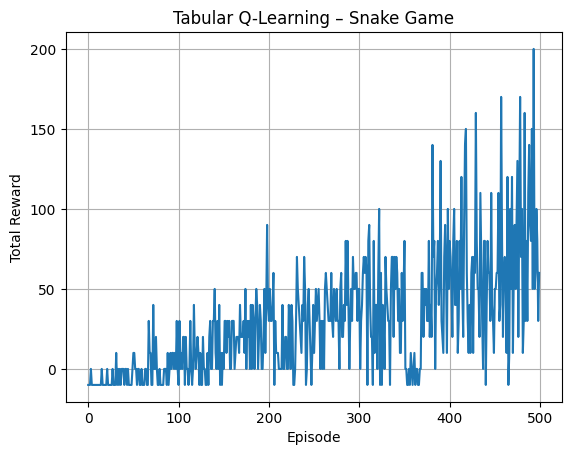

In [7]:
plt.plot(scores_list)
plt.title("Tabular Q-Learning – Snake Game")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

In [8]:
## DQN

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

class SnakeNet(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, outputs)
        )

    def forward(self, x):
        return self.layers(x)

class ExperienceBuffer:
    def __init__(self, limit=50000):
        self.storage = deque(maxlen=limit)

    def add(self, experience):
        self.storage.append(experience)

    def sample(self, count):
        samples = random.sample(self.storage, count)
        return map(lambda x: torch.tensor(x, dtype=torch.float32) if isinstance(x[0], (int, float)) else torch.tensor(x), zip(*samples))

    def __len__(self):
        return len(self.storage)

In [10]:
input_size = 11
action_count = 3
agent = SnakeNet(input_size, action_count)
target = SnakeNet(input_size, action_count)
target.load_state_dict(agent.state_dict())
target.eval()

memory = ExperienceBuffer()
optimizer = optim.Adam(agent.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

def choose_action(state, exploration):
    if random.random() < exploration:
        return random.randint(0, 2)
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            return agent(state).argmax().item()

In [11]:
def update_model(batch_size, gamma):
    if len(memory) < batch_size:
        return

    states, actions, rewards, next_states, dones = memory.sample(batch_size)
    states = states.float()
    next_states = next_states.float()
    actions = actions.long()
    dones = dones.float()

    q_pred = agent(states).gather(1, actions.unsqueeze(1)).squeeze()
    q_next = target(next_states).max(1)[0].detach()
    q_target = rewards + gamma * q_next * (1 - dones)

    loss = loss_fn(q_pred, q_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [12]:
eps = 500
explore = 1.0
explore_decay = 0.995
min_explore = 0.01
batch = 64
gamma = 0.9
swap_rate = 10
dqn_scores = []

for episode in range(eps):
    world = Environment()
    complete = False
    score = 0

    while not complete:
        obs = extract_state(world)
        act = choose_action(obs, explore)
        world.snake.direction = get_new_direction(act, world.snake.direction)
        world.snake.move()

        reward = 0
        lead = world.snake.segments[0]

        if (lead.x < 0 or lead.x >= grid_size or lead.y < 0 or lead.y >= grid_size or lead in world.snake.segments[1:]):
            reward = -10
            complete = True
        elif lead == world.food.position:
            reward = 10
            world.snake.grow()
            world.food.set_random_position()

        new_obs = extract_state(world)
        memory.add((obs, act, reward, new_obs, complete))
        update_model(batch, gamma)

        score += reward

    explore = max(min_explore, explore * explore_decay)
    dqn_scores.append(score)

    if episode % swap_rate == 0:
        target.load_state_dict(agent.state_dict())

    if episode % 50 == 0:
        print(f"Episode {episode} | Score: {score} | Explore: {explore:.3f}")

Episode 0 | Score: -10 | Explore: 0.995
Episode 50 | Score: -10 | Explore: 0.774
Episode 100 | Score: 20 | Explore: 0.603
Episode 150 | Score: 30 | Explore: 0.469
Episode 200 | Score: 70 | Explore: 0.365
Episode 250 | Score: -10 | Explore: 0.284
Episode 300 | Score: 110 | Explore: 0.221
Episode 350 | Score: 30 | Explore: 0.172
Episode 400 | Score: 180 | Explore: 0.134
Episode 450 | Score: 70 | Explore: 0.104


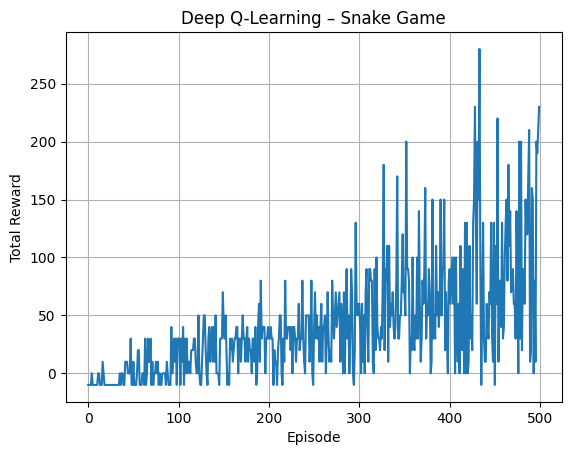

In [13]:
plt.plot(dqn_scores)
plt.title("Deep Q-Learning – Snake Game")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

In [14]:
import math
import time

def display_snake_dqn_run(model, num_games=3, frame_delay=80):
    pygame.font.init()
    font = pygame.font.SysFont("arial", 24)

    for game_id in range(num_games):
        world = Environment()
        over = False
        score = 0
        trail = []

        while not over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            state = extract_state(world)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action = model(state_tensor).argmax().item()

            world.snake.direction = get_new_direction(action, world.snake.direction)
            world.snake.move()

            head = world.snake.segments[0]
            if (head.x < 0 or head.x >= grid_size or
                head.y < 0 or head.y >= grid_size or
                head in world.snake.segments[1:]):
                over = True

            if head == world.food.position:
                world.snake.grow()
                world.food.set_random_position()
                score += 1

            # Track recent tail for glowing trail
            trail.append(head)
            if len(trail) > 15:
                trail.pop(0)

            screen.fill((15, 15, 15))  # Dark background

            for x in range(0, grid_size * block_size, block_size):
                pygame.draw.line(screen, (35, 35, 35), (x, 0), (x, grid_size * block_size))
            for y in range(0, grid_size * block_size, block_size):
                pygame.draw.line(screen, (35, 35, 35), (0, y), (grid_size * block_size, y))

            for i, pos in enumerate(trail[:-1]):
                alpha = int(255 * (i / len(trail)))
                color = (0, 150, 255, alpha)
                surf = pygame.Surface((block_size, block_size), pygame.SRCALPHA)
                pygame.draw.rect(surf, color, (0, 0, block_size, block_size), border_radius=4)
                screen.blit(surf, (pos.x * block_size, pos.y * block_size))

            for segment in world.snake.segments:
                pygame.draw.rect(screen, (0, 255, 200), pygame.Rect(
                    segment.x * block_size, segment.y * block_size, block_size, block_size), border_radius=6)

            time_factor = time.time() * 4
            size_variation = int(2 * math.sin(time_factor))  # pulse effect
            apple_size = block_size + size_variation
            apple_x = int(world.food.position.x * block_size + (block_size - apple_size) / 2)
            apple_y = int(world.food.position.y * block_size + (block_size - apple_size) / 2)

            pygame.draw.ellipse(screen, (255, 220, 50),
                pygame.Rect(apple_x, apple_y, apple_size, apple_size))

            text = font.render(f"Score: {score}", True, (255, 255, 255))
            screen.blit(text, (10, 10))

            pygame.display.update()
            pygame.time.delay(frame_delay)

In [ ]:
display_snake_dqn_run(agent, num_games=2, frame_delay=80)